In [169]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
from scipy.stats import t
import warnings
warnings.filterwarnings("ignore")

In [170]:
trading_symbols = np.array(['STXRAF.JO', 'CTOP50.JO','ETF5IT.JO', 'STXCHN.JO' ])
for symbol in trading_symbols:
    stock = yf.Ticker(symbol)
    historical_data = stock.history(period= '2y')
    closing_prices = historical_data['Close']/100
    if not closing_prices.empty:
        current_price = closing_prices.iloc[-1]
        print(f"Current price for {symbol}: {current_price}")
    else:
        print(f"Could not retrieve data for {symbol}")

Current price for STXRAF.JO: 30.2
Current price for CTOP50.JO: 40.64
Current price for ETF5IT.JO: 33.65
Current price for STXCHN.JO: 55.11


In [171]:
# satrix RAFI
stock = yf.Ticker('STXRAF.JO')
historical_data = stock.history(period= '3y')
stock1 = historical_data['Close']/100
# 10x Top50 ETF
stock = yf.Ticker('CTOP50.JO')
historical_data = stock.history(period= '3y')
stock2 = historical_data['Close']/100
# invest s&p500 info tech index
stock = yf.Ticker('ETF5IT.JO')
historical_data = stock.history(period= '3y')
stock3 = historical_data['Close']/100
# satrix MSCI china
stock = yf.Ticker('STXCHN.JO')
historical_data = stock.history(period= '3y')
stock4 = historical_data['Close']/100

In [172]:
df = pd.DataFrame({'STXRAF.JO': stock1, 'CTOP50.JO': stock2, 'ETF5IT.JO': stock3, 'STXCHN.JO': stock4})

In [173]:
df.describe()

,STXRAF.JO,CTOP50.JO,ETF5IT.JO,STXCHN.JO
count,749.000000,749.000000,749.000000,748.000000
mean,23.377234,32.118707,23.809235,40.923389
std,2.119148,3.118871,6.107093,5.289958
min,18.934467,26.086782,12.948910,29.869800
25%,21.966299,29.875896,19.755909,36.788125
50%,23.187361,31.468862,25.186470,40.028650
75%,24.177700,33.917949,29.010000,43.098750
max,30.200000,40.640000,34.610000,55.110000


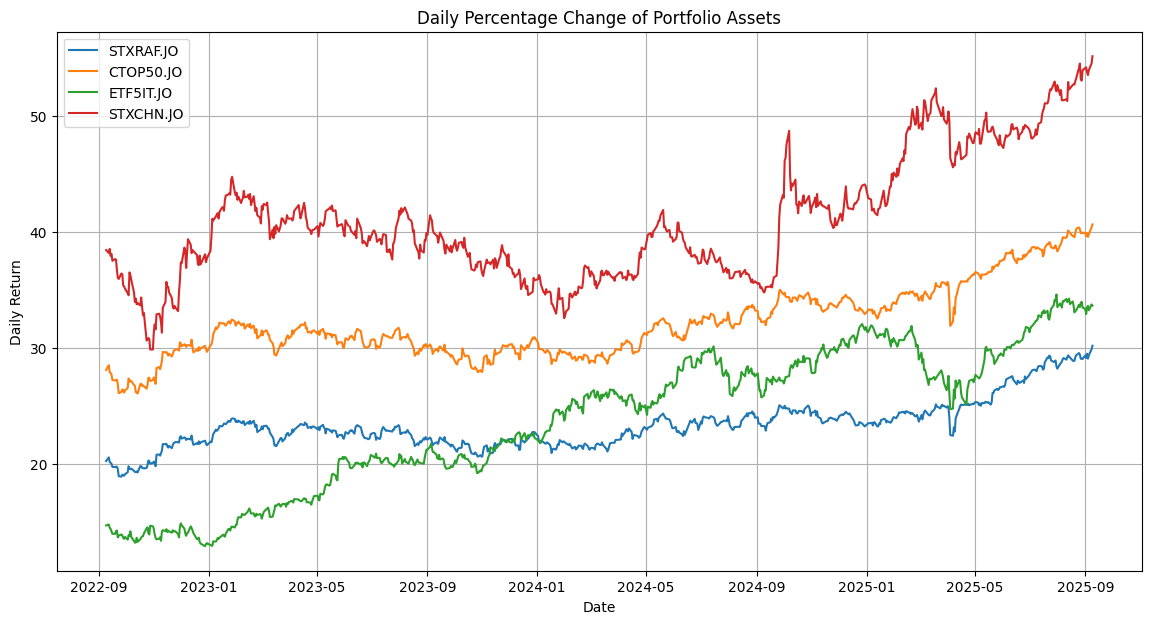

In [174]:
rolling = 10
plt.figure(figsize=(14,7))
plt.plot(df.index, df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Percentage Change of Portfolio Assets')
plt.legend(df.columns)
plt.show()

In [175]:
df.pct_change().sum()*100

,0
STXRAF.JO,43.876659
CTOP50.JO,40.452731
ETF5IT.JO,91.687091
STXCHN.JO,45.670307


<Axes: >

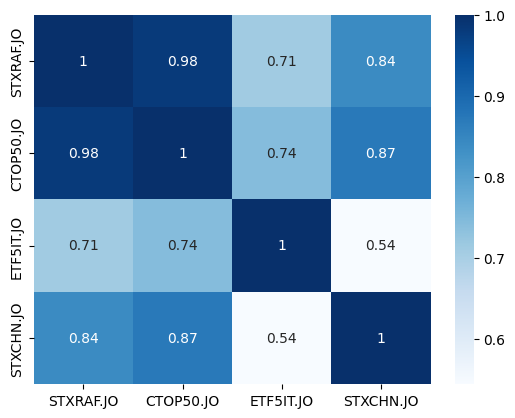

In [176]:
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [177]:
def calculate_returns(price_data):

    return price_data.pct_change().dropna()

def portfolio_metrics(weights, returns):

    weights = np.array(weights)

    # Expected returns (mean of daily returns)
    mean_returns = returns.mean()

    # Covariance matrix
    cov_matrix = returns.cov()

    # Portfolio expected return
    port_return = np.dot(weights, mean_returns)

    # Portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

    # Portfolio standard deviation
    port_std = np.sqrt(port_variance)

    return {
        "Expected Return (daily)": port_return,
        "Variance": port_variance,
        "Standard Deviation": port_std
    }

prices = df

# 2. Calculate returns
returns = calculate_returns(prices)
optimal_weights = [1/4, 1/4, 1/4, 1/4]

# 3. Define portfolio weights (must sum to 1)
weights = optimal_weights

# 4. Calculate portfolio metrics
results = portfolio_metrics(weights, returns)
annual_return = results["Expected Return (daily)"] * 252 * 100
annual_std = results["Standard Deviation"] * np.sqrt(252)


In [178]:
print("Optimal Weights:", optimal_weights)
print("Annualized Return:", round(annual_return, 4))
print("Annualized Std Dev:", round(annual_std, 4))
print("Portfolio Expected Daily Return:", round(results["Expected Return (daily)"], 6))
print("Portfolio Variance:", round(results["Variance"], 6))
print("Portfolio Std Dev (daily):", round(results["Standard Deviation"], 6))

Optimal Weights: [0.25, 0.25, 0.25, 0.25]
Annualized Return: 18.6715
Annualized Std Dev: 0.1418
Portfolio Expected Daily Return: 0.000741
Portfolio Variance: 8e-05
Portfolio Std Dev (daily): 0.00893


📊 Future Value Simulation Results
Mean Final Value: R13306.29
Total Contributed: R12000.00
Sharpe Ratio (FV method): 3.83
95% CI(t-distribution): [R13283.14, R13329.43]


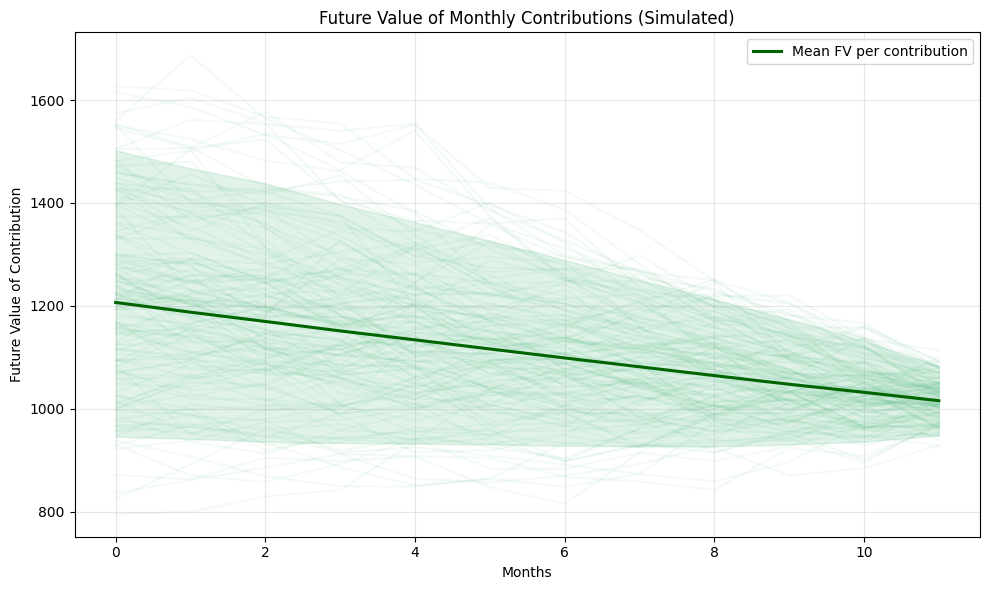

In [179]:

# -------------------------------
# 1. Simulation Parameters
# -------------------------------
monthly_contribution = 1000
investment_months = 12
n_simulations = 10000

# Example daily return and volatility (adjust as needed)
daily_return = results["Expected Return (daily)"]
daily_volatility = results["Standard Deviation"]

# Convert to monthly
monthly_return = (1 + daily_return)**21 - 1
monthly_volatility = daily_volatility * np.sqrt(21)

# -------------------------------
# 2. Simulate Portfolio Paths
# -------------------------------
np.random.seed(42)
portfolio_paths = np.zeros((n_simulations, investment_months))

for i in range(n_simulations):
    monthly_returns = np.random.normal(monthly_return,
                                       monthly_volatility,
                                       investment_months)
    for j in range(investment_months):
        months_remaining = investment_months - j
        future_multiplier = np.prod(1 + monthly_returns[j:])
        fv = monthly_contribution * future_multiplier
        portfolio_paths[i, j] = fv

# -------------------------------
# 3. Final Portfolio Stats
# -------------------------------
final_values = portfolio_paths.sum(axis=1)
mean_final = final_values.mean()
std_final = final_values.std(ddof=1)
total_contributed = monthly_contribution * investment_months

# Sharpe ratio (annualized)
excess_return = (mean_final - total_contributed) / std_final
sharpe_ratio = excess_return * np.sqrt(12)

# -------------------------------
# 4. 95% Confidence Interval (t-distribution)
# -------------------------------
dof = n_simulations - 1
t_crit = t.ppf(0.975, dof)
std_error = std_final / np.sqrt(n_simulations)

ci_lower = mean_final - t_crit * std_error
ci_upper = mean_final + t_crit * std_error

# -------------------------------
# 5. Output Results
# -------------------------------
print("📊 Future Value Simulation Results")
print(f"Mean Final Value: R{mean_final:.2f}")
print(f"Total Contributed: R{total_contributed:.2f}")
print(f"Sharpe Ratio (FV method): {sharpe_ratio:.2f}")
print(f"95% CI(t-distribution): [R{ci_lower:.2f}, R{ci_upper:.2f}]")

# -------------------------------
# 6. Plot Portfolio Paths
# -------------------------------
plt.figure(figsize=(10, 6))
subset = 150
idx = np.random.choice(n_simulations, size=subset, replace=False)
for i in idx:
    plt.plot(range(investment_months), portfolio_paths[i], color='mediumseagreen', alpha=0.06)

mean_path = portfolio_paths.mean(axis=0)
p5 = np.percentile(portfolio_paths, 5, axis=0)
p95 = np.percentile(portfolio_paths, 95, axis=0)

plt.fill_between(range(investment_months), p5, p95, color='mediumseagreen', alpha=0.15)
plt.plot(range(investment_months), mean_path, color='darkgreen', lw=2.2, label='Mean FV per contribution')

plt.title("Future Value of Monthly Contributions (Simulated)")
plt.xlabel("Months")
plt.ylabel("Future Value of Contribution")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
